In [1]:
from matplotlib import pyplot as plt
#%matplotlib inline
#%matplotlib widget #If viewed in Jupyter lab
# calling it a second time may prevent some graphics errors
%matplotlib notebook

#For printing out all the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np

### Input parameters
* Population values obtained from Wikipedia
* and from https://www.varldenshaftigaste.se/topplistor/sveriges-15-storsta-stader/
* Coordinates in degrees obtained from Google Maps
* The cities researched are Malmö, Copenhagen, Visby, Gothenburg, AalBorg, Lund, Jönköping

In [2]:
EndTime = 30    # days
NrIter = 2*10**3
beta = 0.7    # Probability to get infected * times people meet
gamma = 0.04  # Vaccination rate
alpha = 0.1   # Recovery rate
tStart = 0

# population in all of the different cities thousands
N = np.array([316, 780, 24, 600, 100, 92, 97])
# Parts of infected people in brackets
I0 = N*np.array([0.2, 0, 0, 0, 0, 0.3, 0])
# Parts of resistant people in brackets
R0 = N*np.array([0.1, 0.1, 0.01, 0.5, 0.1, 0.4, 0.1])
S0 = N-I0-R0
nrTowns = len(N)

# Coordinates of the towns
# Malmö, Copenhagen, Visby, Gothenburg, AalBorg, Lund, Jönköping
XVal = [13.00, 12.54, 18.296, 11.99, 9.907, 13.186, 14.176]
YVal = [55.55, 55.63, 57.737, 57.720, 57.056, 55.681, 57.808]

In [3]:
h = EndTime/NrIter  # stepsize
time = np.linspace(0, EndTime+1, NrIter+1)  # time in days

Define all of the connections between towns - the flux of people in thousands commuting from the town to each of the other towns. (rows define the town from which people go, columns - the town to with they go; actually numbers in the model are the same in the other way).

In [4]:
ConnectAbs = np.array([  # Malmö, Copenhagen, Visby, Gothenburg, AalBorg, Lund, Jönköping
    [0, 25, 1, 10, 4, 6, 3],
    [25, 0, 0.6, 4, 5, 4, 1],
    [1, 0.6, 0, 2, 0.1, 0.2, 0.6],
    [10, 4, 2, 0, 1, 2, 4],
    [4, 5, 0.1, 1, 0, 0.5, 0.3],
    [6, 4, 0.2, 2, 0.5, 0, 0.7],
    [3, 1, 0.6, 4, 0.3, 0.7, 0]
])

Connect = ConnectAbs/N
np.sum(Connect, 1)  # The sum of people travelling from each town

array([0.22652984, 0.21456813, 0.0166266 , 0.19308335, 0.03342938,
       0.04799871, 0.05305108])

### Do the check for the connection matrix
Check if it is symmetric and if the total fluxes of people from some town is not larger then the popualtion of the town. This way it is easier to fight with bugs

In [5]:
if len(Connect)*len(Connect[0]) != nrTowns**2:
    print("The dimensions are not correct")

if not(np.allclose(ConnectAbs, ConnectAbs.T)):  # If matrices are not the same
    print("ConnectAbs is not symetric")


for i, boolVal in enumerate(np.sum(Connect, 1) > 1):
    if boolVal:
        print("More then 100% of population is moving from the town nr ", i)
if np.diagonal(Connect).any():  # if any in non zeo
    print("Diagonal is not zero")

### Saving the data frame as a Latex table of the data of people flux

In [6]:
# import pandas as pd
# CityNames=["Malmö", "Copenhagen", "Visby", "Gothenburg","AalBorg", "Lund", "Jönköping"]
# Conn = pd.DataFrame(ConnectAbs)
# Conn.columns=CityNames
# Conn.index=CityNames
#with open('mytable.tex','w') as tf:
#    tf.write(Conn.to_latex())

#### We create a three dimensional array that will contain all of the output Var[a,b,c], where *a* index defines type of population (I,S,R), *b* is town, *c* is time

In [7]:
I = np.zeros((nrTowns, NrIter+1))
I[:, 0] = I0
S = np.zeros((nrTowns, NrIter+1))
S[:, 0] = S0
R = np.zeros((nrTowns, NrIter+1))
R[:, 0] = R0

Var = np.array([S, I, R])  #

#### Define all of the derivatives from the moddel as functions and create a list of all of the functions

In [12]:
def SChange(Vari, TownNr, Connect, *args):
    TravelersTo = np.dot(Connect[TownNr, :], Vari[0, :])     #
    TravelersFrom = sum(Connect[:, TownNr]*Vari[0, TownNr])
    Change = -beta*Vari[0, TownNr]*Vari[1, TownNr]/N[TownNr] - \
        gamma*Vari[0, TownNr] + TravelersTo - TravelersFrom
    return(Change)


def IChange(Vari, TownNr, Connect, *args):
    TravelersTo = np.dot(Connect[TownNr, :], Vari[1, :])     #
    TravelersFrom = sum(Connect[:, TownNr]*Vari[1, TownNr])
    Change = beta*Vari[0, TownNr]*Vari[1, TownNr]/N[TownNr] - \
        alpha*Vari[1, TownNr] + TravelersTo - TravelersFrom
    return(Change)


def RChange(Vari, TownNr, Connect, *args):
    TravelersTo = np.dot(Connect[TownNr, :], Vari[2, :])     #
    TravelersFrom = sum(Connect[:, TownNr]*Vari[2, TownNr])
    Change = gamma*Vari[0, TownNr] + alpha * \
        Vari[1, TownNr] + TravelersTo - TravelersFrom
    return(Change)


ChangeList = [SChange, IChange, RChange]  # List of all functions

### Define a function which will do the Runge-Kutta

In [9]:
K1, K2, K3, K4 = np.zeros((4, len(Var), nrTowns))  # Create four zero matrices


def MyRungeKutta(t, *args):  # t - time
    Vari = Var[:, :, t]
    for townNr in range(nrTowns):
        for j, func in enumerate(ChangeList):
            K1[j, townNr] = h*func(Vari, townNr, Connect)

    for townNr in range(nrTowns):
        for j, func in enumerate(ChangeList):
            K2[j, townNr] = h*func(Vari+K1, townNr, Connect)

    for townNr in range(nrTowns):
        for j, func in enumerate(ChangeList):
            K3[j, townNr] = h*func(Vari+K2, townNr, Connect)

    for townNr in range(nrTowns):
        for j, func in enumerate(ChangeList):
            K4[j, townNr] = h*func(Vari+K3, townNr, Connect)

    Var[:, :, t+1] = Var[:, :, t] + K1/6+K2/3 + K3/3 + K4/6

Execute Runge-Kutta

In [10]:
%% time
for i in range(NrIter):
    MyRungeKutta(i)

h**5
max(Var[1, 3])/N[3]

Wall time: 9.82 s


0.16737120220159746

### Plot the result

<IPython.core.display.Javascript object>


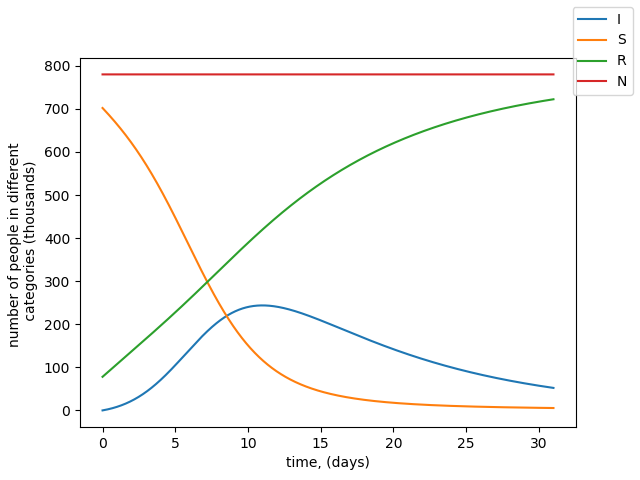

[Text(0, 0.5, 'number of people in different \n categories (thousands)'),
 Text(0.5, 0, 'time, (days)')]

In [11]:
%matplotlib notebook
PlotTown = 1  # Malmö, Copenhagen, Visby, Gothenburg, AalBorg, Lund, Jönköping
fig, ax = plt.subplots()
# fig.set_size_inches(3.7, 3.2) #For putting in pdf need smaller
#fig.subplots_adjust(left=0.21, bottom=0.15)
ax.plot(time, Var[1, PlotTown], label='I')
ax.plot(time, Var[0, PlotTown], label='S')
ax.plot(time, Var[2, PlotTown], label='R')
ax.plot(time, Var[2, PlotTown]+Var[1, PlotTown]+Var[0, PlotTown], label='N')
ax.set(xlabel='time, (days)',
       ylabel='number of people in different \n categories (thousands)')
fig.legend()

### The code bellow was used in an error estimation

In [106]:
#Var1000=Var
# Var2000=Var
# fig, ax=plt.subplots()
# fig.set_size_inches(7.4, 3.5) #For putting in pdf need smaller
# fig.subplots_adjust(left=0.11, bottom=0.15)
# pts=np.arange(0,2002,2)
# ax.plot((Var1000[1,3]-Var2000[1,3,pts])/(2^5-1)/(Var1000[1,3]+0.001),label='Gothenburg')
# ax.plot((Var1000[1,5]-Var2000[1,5,pts])/(2^5-1)/(Var1000[1,5]+0.001),label='Lund')
# ax.plot((Var1000[1,0]-Var2000[1,0,pts])/(2^5-1)/(Var1000[1,0]+0.001),label='Malmö')
# ax.set(xlabel='time, (days)',
#             ylabel='The relative error of infected people')
# fig.legend()


### Eulers algorithm if you wish 

In [58]:
# def Euler(t,*args):
#     Vari=Var[:,:,t]
#     for townNr in range(nrTowns):
#         for j, func in enumerate(ChangeList):
#             Var[j,townNr,t+1]=Var[j,townNr,t] +h*func(Vari,townNr,Connect)

In [59]:
# %%time
# for i in range(NrIter):
#     Euler(i)

# PlotTown=0
# fig, ax=plt.subplots()
# ax.plot(time,Var[1,PlotTown],label='I')
# ax.plot(time,Var[0,PlotTown],label='S')
# ax.plot(time,Var[2,PlotTown],label='R')
# ax.plot(time,Var[2,PlotTown]+Var[1,PlotTown]+Var[0,PlotTown],label='N')
# fig.legend()

Wall time: 1.35 s


Error for the Eulers method

<IPython.core.display.Javascript object>


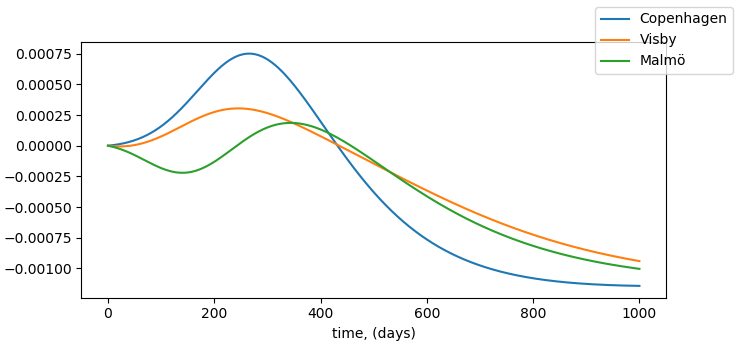

[Text(0, 0.5, 'The relative error of infected people'),
 Text(0.5, 0, 'time, (days)')]

In [67]:
#Var2000=Var
# Var1000=Var
# fig, ax=plt.subplots()
# fig.set_size_inches(7.4, 3.5) #For putting in pdf need smaller
# fig.subplots_adjust(left=0.11, bottom=0.15)
# pts=np.arange(0,2002,2)
# ax.plot((Var1000[0,1]-Var2000[0,1,pts])/(2^2-1)/(Var1000[0,1]+0.001),label='Copenhagen')
# ax.plot((Var1000[0,2]-Var2000[0,2,pts])/(2^2-1)/(Var1000[0,2]+0.001),label='Visby')
# ax.plot((Var1000[0,0]-Var2000[0,0,pts])/(2^2-1)/(Var1000[0,0]+0.001),label='Malmö')
# ax.set(xlabel='time, (days)',
#             ylabel='The relative error of infected people')
# fig.legend()

### Animation

<IPython.core.display.Javascript object>


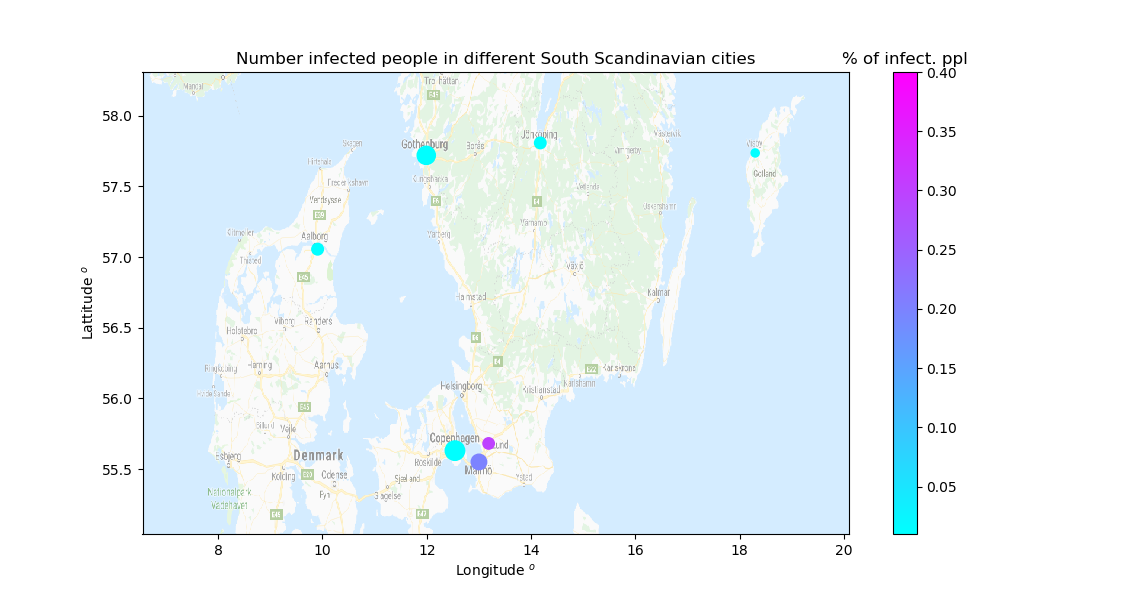

Text(0.5, 1.0, '% of infect. ppl')

[Text(0, 0.5, 'Lattitude $^o$'),
 Text(0.5, 0, 'Longitude $^o$'),
 Text(0.5, 1.0, 'Number infected people in different South Scandinavian cities')]

In [15]:
# %%capture
%matplotlib notebook
%matplotlib notebook
import numpy as np
import matplotlib.image as mpimg
from matplotlib import animation, rc
from IPython.display import HTML

california_img = mpimg.imread('SouthScandinavia.png')
fig, ax = plt.subplots()
fig.set_size_inches(11.4, 6.0)
im = plt.imshow(california_img, extent=[
                6.55, 20.10, 55.04, 58.31], alpha=0.5, aspect='auto')

scat = ax.scatter(XVal, YVal, c=Var[1, :, 0]/N, cmap='cool',
                  s=np.sqrt(N)*7, norm=None, vmin=0.01, vmax=0.40)
clb = plt.colorbar(scat)
clb.ax.set_title('% of infect. ppl')
# ,title='Number infected people in different South Scandinavian cities')
ax.set(xlabel="Longitude $^o$", ylabel='Lattitude $^o$',title='Number infected people in different South Scandinavian cities')

# fig.set_size_inches(8.3, 3.6) #For putting in pdf need smaller
#fig.subplots_adjust(left=0.08, bottom=0.15,right=1.05)


def update_plot(i, data, scat):
    scat.set_array(data[:, i*33]/N)
    return (scat,)


ani = animation.FuncAnimation(fig, update_plot, frames=np.int(NrIter/33),  # NrIter/33 will give 60 frames
                              fargs=(Var[1, :, :], scat))

In [16]:
%%time
# HTML(ani.to_jshtml())
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
Name="Animation of infected people.mp4"
ani.save(Name, writer=writer)

Wall time: 21.4 s
